In [16]:
# pip install keras-tuner

In [17]:
import pandas as pd
from IPython.display import clear_output
import io
import os
import glob
import zipfile
import shutil


import numpy as np
import random as python_random
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping

# from kerastuner.tuners import RandomSearch
# from kerastuner import Objective

import sklearn.metrics as sklm
from cxr_foundation import embeddings_data

seed=19
np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

In [18]:
base_path="D:/Vector_Embedding/MIMIC_CXR_EMB"

In [19]:
data_df=pd.read_csv(base_path+"/Extracted_Embeddings/processed_mimic_df.csv")

In [20]:
data_df.split.value_counts()

split
train       108952
validate     13936
test         13574
Name: count, dtype: int64

In [21]:
df_train = data_df[data_df["split"] == "train"]
df_validate = data_df[data_df["split"] == "validate"]

df_test = data_df[data_df["split"] == "test"]

# Preparing Embeddings Files for Model Training

We want to detect race of a patient using the embeddings with this label.

In [22]:
TrueWithMeta = df_test.loc[:, ~df_test.columns.isin(['study_id','split'])]
TrueWithMeta.reset_index(drop=True,inplace=True)
print(f'length of df_test : {len(TrueWithMeta)}')

# base_path="D:/Academics/Master/Thesis/MIMIC_CXR_EMB/Vector_Embedded/Seed_"+str(seed)+"/"
#base_path

prediction_results_path=os.path.join(base_path+"/Prediction_Results/")
os.makedirs(os.path.dirname(prediction_results_path),exist_ok=True)
TrueWithMeta.to_csv(prediction_results_path+"TrueWithMeta.csv")


print(f'prediction path : {prediction_results_path}')

length of df_test : 13574
prediction path : D:/Vector_Embedding/MIMIC_CXR_EMB/Prediction_Results/


In [23]:
labels_Columns=['Atelectasis','Cardiomegaly','Consolidation','Edema','Enlarged_Cardiomediastinum',
        'Fracture','Lung_Lesion','Lung_Opacity','No_Finding','Pleural_Effusion','Pleural_Other',
        'Pneumonia','Pneumothorax','Support_Devices']


In [24]:
# Create training and validation Datasets
training_data = embeddings_data.get_dataset(filenames=df_train.path.values,
                        labels=df_train[labels_Columns].values)

validation_data = embeddings_data.get_dataset(filenames=df_validate.path.values,
                        labels=df_validate[labels_Columns].values)

In [25]:
for data in training_data.take(2):
  print(data)

(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.36118683, -0.5544699 ,  0.82848966, ..., -1.2692559 ,
        0.8680941 , -1.7307097 ], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([ 0.00790492, -1.233756  ,  1.4638388 , ...,  0.16128573,
        1.1709231 , -2.2127128 ], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])>)


In [26]:
for data in validation_data.take(2):
  print(data)

(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.76881164, -0.35455763,  0.55263436, ..., -1.7078307 ,
        0.55289423, -0.67891777], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.])>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.37028256, -0.4382674 , -0.18898396, ..., -1.2663532 ,
        0.11181889, -0.8853314 ], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])>)


In [27]:

test_data = embeddings_data.get_dataset(filenames=df_test.path.values,labels=df_test[labels_Columns].values)
for _d in test_data.take(2):
  print(_d)


(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([ 0.75120676, -1.6077417 ,  1.1188964 , ..., -1.0535457 ,
        1.2617992 , -0.6080363 ], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.7226969, -1.5087104,  0.94791  , ..., -1.3294164,  1.1765957,
       -0.6002594], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])>)


# Create and Train Model

### Optimal hyperparameters


In [28]:
# These parameters are obtained by doing hyperparameter tuning 
embeddings_size=1376
learning_rate=0.0001253
batch_size = 32
epochs = 50
end_lr_factor=1.0
dropout=0.4
decay_steps=1000
loss_weights=None
weight_decay = 1.1342834436836775e-05
hidden_layer_sizes = [192]


In [29]:
checkpoint_path = base_path+"/model_checkpoint/"
# Create directory model weightes saving
save_model_dir = os.path.join(checkpoint_path,'models')
os.makedirs(os.path.dirname(save_model_dir), exist_ok=True)

def get_callbacks(patience=5):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)

    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{save_model_dir}/model.h5',
                                                    monitor='val_auc',
                                                    mode='max',
                                                    save_freq='epoch',
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop,
                      saved_model,
                     ]
    return callbacks_list

In [30]:
# Define a function to build the model
def build_model(
    # hp
    ):

    #Hyperparameters
    # learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    # batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128,256])
    # dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    # weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='log')
    # hidden_layer_sizes = [hp.Int(f'hidden_{i}', min_value=64, max_value=512, step=64) for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=4))]

    # Define the input layer
    inputs = Input(shape=(embeddings_size,))

    # Build the model using the Functional API
    hidden = inputs
    for size in hidden_layer_sizes:
        hidden = Dense(size,
                       activation='relu',
                       kernel_initializer=HeUniform())(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dropout(dropout)(hidden)

    output = Dense(len(labels_Columns), activation='sigmoid', kernel_initializer=HeUniform())(hidden)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model with AUC as the metric
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(multi_label=True)])

    return model

In [31]:
# # Create the tuner
# tuner = RandomSearch(build_model,
#                      objective=Objective('val_auc', direction='max'),
#                      max_trials=10,  # Number of trials to run
#                      executions_per_trial=1,  # Number of executions per trial (use more for better robustness)
#                      directory='tuner_directory',
#                      project_name='my_tuning_project')


In [32]:
# # Start the hyperparameter search
# tuner.search(x=training_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
#              batch_size=batch_size,
#              epochs=20,
#              validation_data=validation_data.batch(batch_size).cache(),
#              callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

In [33]:
# # Get the best hyperparameters
# best_hyperparameters = tuner.get_best_hyperparameters()[0]
# print("Best Hyperparameters:")
# print(best_hyperparameters.values)

In [34]:
# # Build and compile the model using the best hyperparameters
# best_model = tuner.hypermodel.build(best_hyperparameters)
# best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters.get('learning_rate')),
#                    loss='binary_crossentropy',
#                    metrics=[AUC(multi_label=True)])

In [35]:
model=build_model()

In [36]:

plt.figure(figsize=(12, 8))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1376)]            0         
                                                                 
 dense (Dense)               (None, 192)               264384    
                                                                 
 batch_normalization (Batch  (None, 192)               768       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                2702      
                                                                 


Total params: 267854 (1.02 MB)
Trainable params: 267470 (1.02 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


<Figure size 1200x800 with 0 Axes>

In [37]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [38]:
# train the model
history=model.fit(
    x=training_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(batch_size).cache(),
    callbacks = get_callbacks(patience=5),
    epochs=50,
)

Epoch 1/50
   3404/Unknown - 171s 50ms/step - loss: 0.3319 - auc: 0.7061
Epoch 1: val_auc improved from -inf to 0.82024, saving model to D:/Vector_Embedding/MIMIC_CXR_EMB/model_checkpoint/models\model.h5
3405/3405 [==============================] - 193s 57ms/step - loss: 0.3318 - auc: 0.7062 - val_loss: 0.2305 - val_auc: 0.8202
Epoch 2/50
   9/3405 [..............................] - ETA: 24s - loss: 0.2414 - auc: 0.7793

C:\Users\gebre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3404/3405 [============================>.] - ETA: 0s - loss: 0.2395 - auc: 0.7974
Epoch 2: val_auc improved from 0.82024 to 0.82756, saving model to D:/Vector_Embedding/MIMIC_CXR_EMB/model_checkpoint/models\model.h5
3405/3405 [==============================] - 22s 6ms/step - loss: 0.2394 - auc: 0.7974 - val_loss: 0.2283 - val_auc: 0.8276
Epoch 3/50
3405/3405 [==============================] - ETA: 0s - loss: 0.2351 - auc: 0.8089
Epoch 3: val_auc did not improve from 0.82756
3405/3405 [==============================] - 21s 6ms/step - loss: 0.2351 - auc: 0.8089 - val_loss: 0.2269 - val_auc: 0.8272
Epoch 4/50
3404/3405 [============================>.] - ETA: 0s - loss: 0.2330 - auc: 0.8145
Epoch 4: val_auc improved from 0.82756 to 0.83265, saving model to D:/Vector_Embedding/MIMIC_CXR_EMB/model_checkpoint/models\model.h5
3405/3405 [==============================] - 21s 6ms/step - loss: 0.2330 - auc: 0.8145 - val_loss: 0.2265 - val_auc: 0.8326
Epoch 5/50
3399/3405 [========================

In [39]:
os.listdir(save_model_dir)

['model.h5']

In [40]:
print('======== Loading saved model ========================')
model.load_weights(f'{save_model_dir}/model.h5')

======== Loading saved model ========================


In [41]:
# Set the learning phase to inference mode
tf.keras.backend.set_learning_phase(False)

C:\Users\gebre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [42]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Evaluate using ROC-AUC
y_pred_prob = model.predict(test_data.batch(batch_size))
#dict(zip(model.metrics_names, y_pred_prob))
y_pred_prob[0]

425/425 [==============================] - 24s 55ms/step


array([2.21307892e-02, 1.85567606e-02, 1.17633073e-03, 1.21873885e-03,
       4.77932813e-03, 6.34017074e-03, 7.64697744e-03, 1.70839168e-02,
       8.97521019e-01, 4.70431009e-03, 7.57015194e-04, 1.18337665e-02,
       1.78959779e-03, 4.81140055e-03], dtype=float32)

In [43]:
roc_auc_scores = []
for i in range(14):
    roc_auc = roc_auc_score(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc_scores.append(roc_auc)

average_roc_auc = np.mean(roc_auc_scores)
print("Average ROC-AUC:", round(average_roc_auc,2))

Average ROC-AUC: 0.84


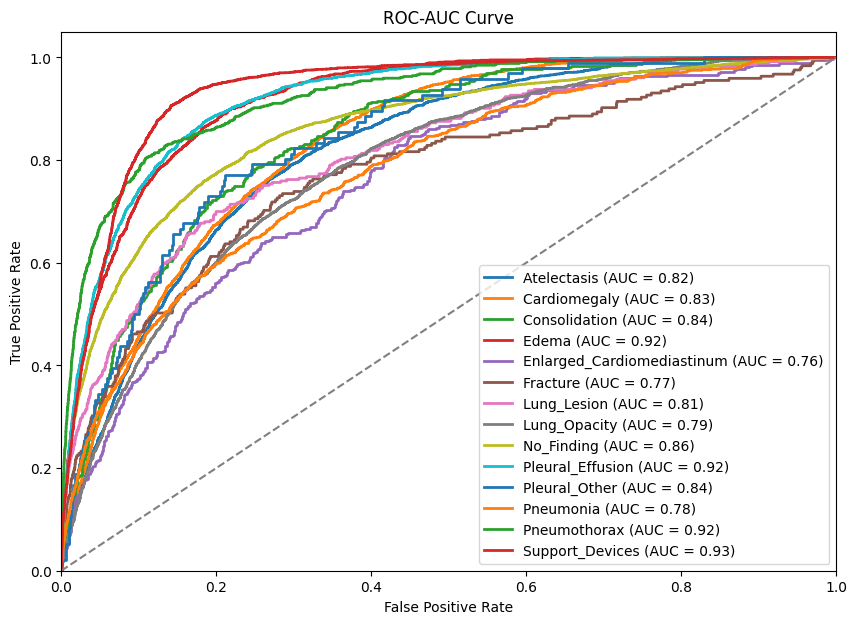

In [44]:
# Plot ROC-AUC curve for each class
plt.figure(figsize=(10, 7))
for i, label_name in enumerate(labels_Columns):
    fpr, tpr, _ = roc_curve(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

## Binray Classification

* Create a list of thresholds, calculate each threshold's precision, recall, and f1 score, and then return the threshold that produces the highest f1 score all based on validation set.

In [45]:

def make_pred_multilabel(model, test_dataset, validation_dataset, test_df):

    #Load  pre-trained Keras model
    PRED_LABELS = labels_Columns

    for mode in ["Threshold", "test"]:
        # Create empty dataframes
        #break
        pred_df = pd.DataFrame(columns=["path"])
        bi_pred_df = pd.DataFrame(columns=["path"])
        true_df = pd.DataFrame(columns=["path"])

        if mode == "Threshold":
            data = validation_dataset  # Use validation dataset for threshold mode
            Eval_df = pd.DataFrame(columns=["label", 'bestthr'])
            thrs = []

        if mode == "test":
            data = test_dataset  # Use test dataset for test mode
            index=0
            TestEval_df = pd.DataFrame(columns=["label", 'auc', "auprc","accuracy"])

            Eval = pd.read_csv(prediction_results_path+"/Threshold.csv")  # Load threshold values from the CSV
            Eval.head(14)
            thrs = [Eval["bestthr"][Eval[Eval["label"] == label].index[0]] for label in PRED_LABELS]

            print("thrs :",thrs)

        for inputs, labels in data:
            # Get predictions from the pre-trained model
            inputs = tf.constant(inputs, dtype=tf.float32)
            true_labels = labels.numpy()
            model.set_weights(model.get_weights())

            """ perform inference
              ... use tf.expand_dims(inputs, axis=0) adds an extra dimension at axis 0,
              ... effectively creating a batch of size 1. """

            inputs_batched = tf.expand_dims(inputs, axis=0)
            outputs = model(inputs_batched, training=False)
            probs = outputs.numpy()

            thisrow = {}
            bi_thisrow = {}
            truerow = {}

            # thisrow['path']='path'
            # truerow['path']='path'

            if mode == "test":
              path=test_df.iloc[index]['path']
              bi_thisrow['path']=path

            # Iterate over each entry in prediction vector; each corresponds to an individual label
            for j, _label in enumerate(PRED_LABELS):
                thisrow["prob_" + _label] = probs[0][j]
                truerow[_label] = true_labels[j]

                if mode == "test":
                   bi_thisrow["bi_" + _label] = probs[0][j] >= thrs[j]

            pred_df = pd.concat([pred_df, pd.DataFrame([thisrow])], ignore_index=True)
            true_df = pd.concat([true_df, pd.DataFrame([truerow])], ignore_index=True)

            if mode == "test":
              #Explicitly cast object-dtype columns with boolean values to bool
              bool_columns = [col_name for col_name in bi_pred_df.columns if col_name != 'path'
               and bi_pred_df[col_name].dtype == 'object']
              bi_pred_df[bool_columns] = bi_pred_df[bool_columns].astype(bool)

              #Append the dictionary to the DataFrame
              bi_pred_df = pd.concat([bi_pred_df, pd.DataFrame([bi_thisrow])], ignore_index=True)
              index=index+1



        #print(f'Last indext in thershold : {index}')
        for column in true_df:
          if column not in PRED_LABELS:
            continue
          actual = true_df[column]
          pred = pred_df["prob_" + column]

          thisrow = {}
          thisrow['label'] = column
          if mode == "test":
            bi_pred = bi_pred_df["bi_" + column]
            thisrow['auc'] = np.nan
            thisrow['accuracy'] = np.nan
            thisrow['auprc'] = np.nan
          else:
            thisrow['bestthr'] = np.nan

          try:

            if mode == "test":
              # Calculate the AUC using the true labels and predicted probabilities
              thisrow['auc'] =sklm.roc_auc_score(actual.astype(int),pred)

              thisrow['auprc'] = sklm.average_precision_score(
                  actual.astype(int), pred)

              #Calculate accuracy
              thisrow['accuracy'] = sklm.accuracy_score(actual.astype(int), bi_pred)
            else:

              p, r, t = sklm.precision_recall_curve(actual.astype(int), pred)

              #Calculate F1-score, handling division by zero
              f1_scores = []
              for precision, recall in zip(p, r):
                if precision + recall == 0:
                  f1_scores.append(0.0)  # Handle division by zero
                else:
                  f1_scores.append(2 * (precision * recall) / (precision + recall))

              #Find the threshold that maximizes F1-score
              best_threshold = t[np.argmax(f1_scores)]

              thrs.append(best_threshold)
              thisrow['bestthr'] = best_threshold

          except BaseException as be:
            #Handle the exception
            print(f'can not caclucalte AUC and Accuracy for  : {str(column)}, see the error : {str(be)}')

          if mode == "Threshold":
            Eval_df = pd.concat([Eval_df, pd.DataFrame([thisrow])], ignore_index=True)

          if mode == "test":
            TestEval_df = pd.concat([TestEval_df, pd.DataFrame([thisrow])], ignore_index=True)


        # Save results to CSV

        if mode == "Threshold":
          Eval_df.to_csv(prediction_results_path+"/Threshold.csv", index=False)

        if mode == "test":
          TestEval_df.to_csv(prediction_results_path+"TestEval.csv", index=False)
          bi_pred_df.to_csv(prediction_results_path+"bipred.csv", index=False)


    avg_AUC=TestEval_df['auc'].sum() / 14.0
    avg_accuracy=TestEval_df['accuracy'].sum() / 14.0

    print("AUC ave:", round(avg_AUC,2))
    #print("auprc ave:", TestEval_df['auprc'].sum() / 14.0)
    print("Accuracy ave:", round(avg_accuracy,2))
    print("done")

    #return pred_df, Eval_df, bi_pred_df,TestEval_df


In [46]:
#path_image = path_to_image_files  # Replace with the path to your image files
make_pred_multilabel(model, test_data,
                                                              validation_data,TrueWithMeta)

thrs : [0.2660433, 0.2865805, 0.09963464, 0.18636687, 0.06643369, 0.07507459, 0.108528726, 0.28128833, 0.385266, 0.3620232, 0.058471695, 0.15074101, 0.17500342, 0.43990844]
AUC ave: 0.84
Accuracy ave: 0.88
done
